In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:

# 1. Charger les données
df = pd.read_csv("../data/processed/df_filtre.csv", sep="\t", encoding="latin1")

# 2. Transformations temporelles
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Heure"] = pd.to_datetime(df["Heures"], format="%H:%M", errors="coerce").dt.hour

# 3. Variables temporelles fines
df["Heure_sin"] = np.sin(2 * np.pi * df["Heure"] / 24)
df["Heure_cos"] = np.cos(2 * np.pi * df["Heure"] / 24)
df["Mois"] = df["Date"].dt.month
df["Jour_du_mois"] = df["Date"].dt.day
df["Semaine"] = df["Date"].dt.isocalendar().week
df["Jour_de_l_annee"] = df["Date"].dt.dayofyear
df["Jour_semaine_binaire"] = df["Weekend"]
df["periode_froide"] = ((df["Saison"] == "Hiver") & ((df["Heure"] <= 8) | (df["Heure"] >= 18))).astype(int)

# 4. Encodage des variables catégorielles
df_encoded = pd.get_dummies(df, columns=["Jour", "Saison", "Type de jour TEMPO"], drop_first=True)

# 5. Définition des features (avec prévision J et J-1)
features = [
    "Prévision J", "Prévision J-1", "Heure_sin", "Heure_cos", "Mois",
    "Jour_du_mois", "Semaine", "Jour_de_l_annee", "Jour_semaine_binaire", "periode_froide"
] + [col for col in df_encoded.columns if col.startswith(("Jour_", "Saison_", "Type de jour TEMPO_"))]

X = df_encoded[features]
y = df_encoded["Consommation"]

# 6. Pipeline : standardisation + modèle
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(n_estimators=20, random_state=42))  # Moins d'arbres pour aller vite
])
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
# 7. Validation croisée temporelle rapide
tscv = TimeSeriesSplit(n_splits=3)
rmse_scores = -cross_val_score(
    pipeline, X, y, cv=tscv,
    scoring = make_scorer(rmse, greater_is_better=False)
)





# 8. Résultat
print("✅ Validation croisée avec Random Forest :")
print(f"RMSE moyen : {rmse_scores.mean():.2f} MW")
print(f"Écart-type RMSE : {rmse_scores.std():.2f} MW")


✅ Validation croisée avec Random Forest :
RMSE moyen : 733.45 MW
Écart-type RMSE : 58.52 MW


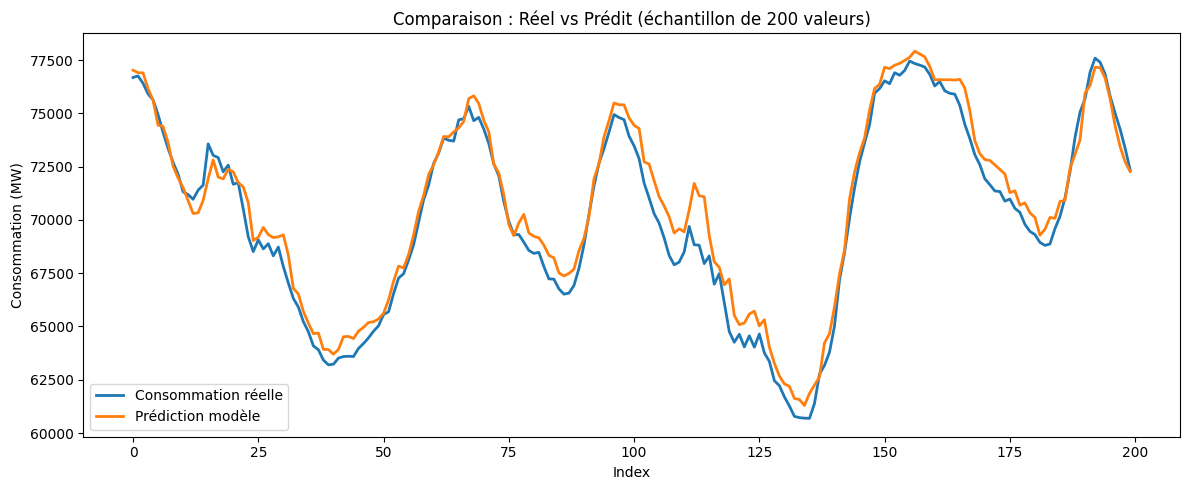

In [3]:
# 1. Repartage simple des données pour visualisation (80% train / 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2  # Pas de shuffle pour préserver la chronologie
)

# 2. Pipeline entraîné sur l'ensemble d'entraînement
pipeline.fit(X_train, y_train)

# 3. Prédictions sur l'ensemble test
y_pred = pipeline.predict(X_test)
# 4. Visualisation des 200 premières valeurs test vs prédiction
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:200], label="Consommation réelle", linewidth=2)
plt.plot(y_pred[:200], label="Prédiction modèle", linewidth=2)
plt.title("Comparaison : Réel vs Prédit (échantillon de 200 valeurs)")
plt.xlabel("Index")
plt.ylabel("Consommation (MW)")
plt.legend()
plt.tight_layout()
plt.show()

Points positifs :
Bonne synchronisation temporelle :

Les deux courbes suivent la même dynamique : montées, descentes, pics → le modèle a bien capté les tendances générales.

Pas de décalage temporel :

Pas de "retard" ou "avance" dans les prédictions → bon respect de la structure temporelle.

Précision sur les cycles moyens :

Le modèle est très proche des valeurs réelles pendant les phases de consommation stable.

⚠️ Légers points à améliorer :
Pics de consommation légèrement surestimés ou sous-estimés :

Sur les sommets ou les creux (ex. indices 90, 110, 150), la prédiction est parfois un peu lissée → le modèle a tendance à modérer les extrêmes.

Typique de Random Forest : il prédit une moyenne pondérée de situations similaires, ce qui peut aplanir les pics.

Erreur visible sur quelques fluctuations rapides :

Dans des zones très dynamiques (ex. entre les indices 30–50 ou 130–150), la courbe orange ne suit pas toujours les micro-variations → à creuser si tu veux affiner la granularité horaire ou ajouter plus de contexte (comme température).

🎯 Conclusion :
Observation	Évaluation
Suivi global de la consommation	✅ Excellent
Synchronisation des tendances	✅ Très bonne
Gestion des extrêmes	⚠️ Moyenne (pics lissés)
Modèle prêt pour prédiction réelle	✅ Oui, solide